In [1]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm.notebook import tqdm
import torch.optim as optim
import torch.nn as nn
from PIL import Image
import torchvision
import shutil
import torch
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import cv2

# **Exploratory data analysis (EDA)**

In [2]:
# Check the root
root_path = "/kaggle/input/gan-getting-started"
os.listdir(root_path)
# Reading img in rgb
read_img = lambda path: cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)


In [3]:
# Load a sample image of monet and photo
data_path = f"{root_path}/photo_jpg"
sample_photo = read_img(os.path.join(data_path, os.listdir(data_path)[0]))

data_path = f"{root_path}/monet_jpg"
sample_monet = read_img(os.path.join(data_path, os.listdir(data_path)[0]))
sample_photo.shape

(256, 256, 3)

In [4]:
sample_photo.min(), sample_photo.max(), sample_photo.dtype

(0, 255, dtype('uint8'))

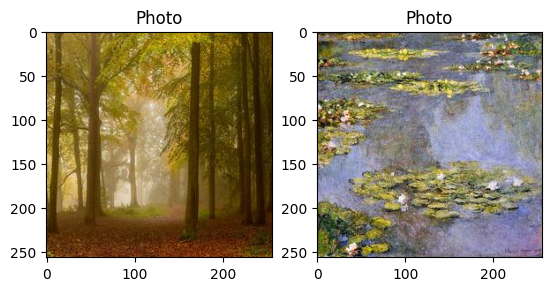

In [5]:
# Photo
plt.subplot(121)
plt.title("Photo")
plt.imshow(sample_photo)  

# Monet
plt.subplot(122)
plt.title("Photo")
plt.imshow(sample_monet)

# **Model Building**

In [6]:
class PaintingsDataset(Dataset):
    '''
    Basic dataset class, will be used to manipulate the monet dataset 
    
    __init__ args:          folder_path       :       path to folder with dataset images
                            transform         :       transform module from torchvision for data augmentation
                            __len__           :       number of images in dataset
                            __get_item__      :       returns image at index idx tranformed
                            __get_crude_item_ :       returns image at index idx 
                            
                
    '''
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image
    
    def __get_crude_item__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        return image
        

In [7]:
# Device and tensors configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor

# Hyperparameters
batch_size = 6
lr = 2e-4
n_epoches = 100
display_epoch = 20

"""
Tranform module:

only applying GaussianBlur to dataset, more transformations seemed like a over-kill

"""
transform = transforms.Compose([
    transforms.Resize((256, 256)),

    # Data augmentation 
    #transforms.ElasticTransform(alpha=150.0),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 3.)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.15, 0.15, 0.15], std=[0.5, 0.5, 0.5])
])

In [8]:
# Initialize datasets
monet_dataset = PaintingsDataset('/kaggle/input/gan-getting-started/monet_jpg', transform)
photo_dataset = PaintingsDataset('/kaggle/input/gan-getting-started/photo_jpg', transform)


# Initialize data loaders
monet_loader = DataLoader(monet_dataset, batch_size=batch_size, shuffle=True)
photo_loader = DataLoader(photo_dataset, batch_size=batch_size, shuffle=True)

In [9]:
monet_loader.dataset.__len__()

300

In [10]:
def show_images(n, dataset):
    ex_im_transf = dataset.__getitem__(n)
    ex_im_crude  = dataset.__get_crude_item__(n)

    im_transf = np.squeeze(ex_im_transf) 
    im_crude = np.squeeze(ex_im_crude)

    f, axarr = plt.subplots(1,2)

    for i in range(2):
        axarr[i].axes.get_xaxis().set_visible(False)
        axarr[i].axes.get_yaxis().set_visible(False)

    axarr[1].imshow(im_transf.permute(1, 2, 0))
    axarr[0].imshow(im_crude)
    axarr[1].set_title("Transformed image")
    axarr[0].set_title("Original image")
    plt.show()

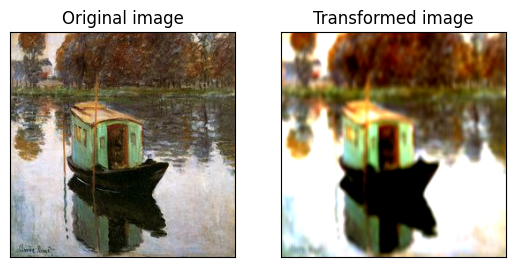

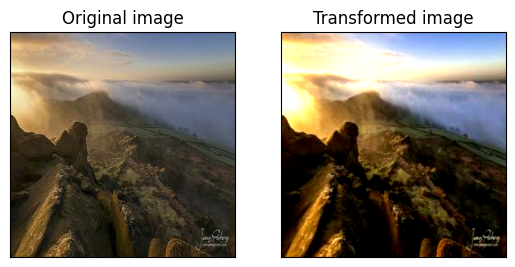

In [11]:
# Visualize data augmentation in both datasets
randn = random.randint(1,298)
show_images(n=randn, dataset=monet_dataset)
show_images(n=randn, dataset=photo_dataset)

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        channels_img = 3
        features_d = 64
        
        self.model = nn.Sequential(
            # Input : N x 3 x 256 x 256
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            # Downsampling blocks
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),

            # Upscaling blocks
            self._conv2d_transpose(features_d * 8, features_d * 4, 3, 2, 1, 1),
            self._conv2d_transpose(features_d * 4, features_d * 2, 3, 2, 1, 1),
            self._conv2d_transpose(features_d * 2, features_d, 3, 2, 1, 1),

            # Final convolutional layer
            nn.Conv2d(features_d, 1, kernel_size=3, stride=2, padding=1)
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def _conv2d_transpose(self, in_channels, out_channels, kernel_size, stride, padding, output_padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.model(x)
    
    
class Generator(nn.Module):
    def __init__(self, num_residual_blocks=9):
        super(Generator, self).__init__()
        
        channels_img = 3
        features_g = 64
        
        # Initial convolution layer
        self.initial = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(channels_img, features_g, kernel_size=7, stride=1, padding=0),
            nn.InstanceNorm2d(features_g),
            nn.ReLU(inplace=True)
        )

        # Downsample layers
        self.downsample_blocks = nn.Sequential(
            self._downsample_block(features_g, features_g * 2),
            self._downsample_block(features_g * 2, features_g * 4)
        )

        # Residual blocks
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(features_g * 4) for _ in range(num_residual_blocks)]
        )

        # Upsample layers
        self.upsample_blocks = nn.Sequential(
            self._upsample_block(features_g * 4, features_g * 2),
            self._upsample_block(features_g * 2, features_g)
        )

        # Output layer
        self.output = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(features_g, channels_img, kernel_size=7, stride=1, padding=0),
            nn.Tanh()
        )

    def _downsample_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def _upsample_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.downsample_blocks(x)
        x = self.residual_blocks(x)
        x = self.upsample_blocks(x)
        return self.output(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

In [13]:
G = Generator()
D = Discriminator()

models = [G, D]
for model in models:
    if torch.cuda.is_available():
        model.cuda()

optimizer_G = torch.optim.RMSprop(G.parameters(), lr=lr)
optimizer_D = torch.optim.RMSprop(D.parameters(), lr=lr)

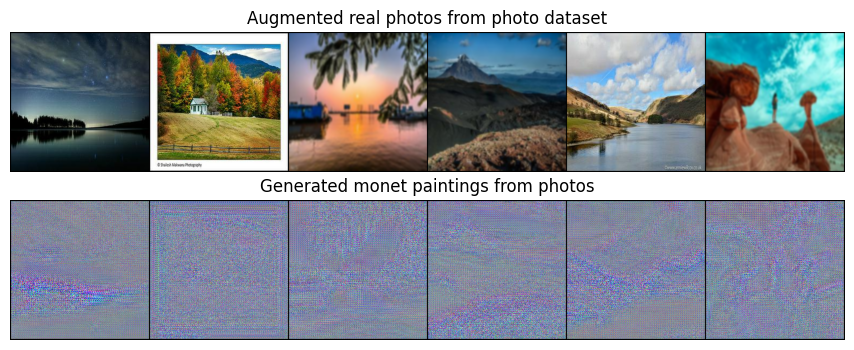

In [14]:
def sample_images(real_X):    
    # turn off some learning parameters in order to evaluate model:
    G.eval()
    
    # transform to tensor and plot images
    real_pic = real_X.type(Tensor)
    artificial_pic = G(real_X).detach()

    ncols = real_X.size(0)
    real_pic_grid = make_grid(real_pic, nrow=ncols, normalize=True)
    artificial_pic_grid = make_grid(artificial_pic, nrow=ncols, normalize=True)

    fig, axs = plt.subplots(2, 1, figsize=(20, 4))  

    axs[0].imshow(real_pic_grid.permute(1, 2, 0).cpu())
    axs[0].set_title("Augmented real photos from photo dataset")
    axs[0].axis('off')

    axs[1].imshow(artificial_pic_grid.permute(1, 2, 0).cpu())
    axs[1].set_title("Generated monet paintings from photos")
    axs[1].axis('off')


    plt.show()

real_X = next(iter(photo_loader))
real_Y = next(iter(photo_loader))
sample_images(real_X.to(device))

  0%|          | 0/100 [00:00<?, ?it/s]

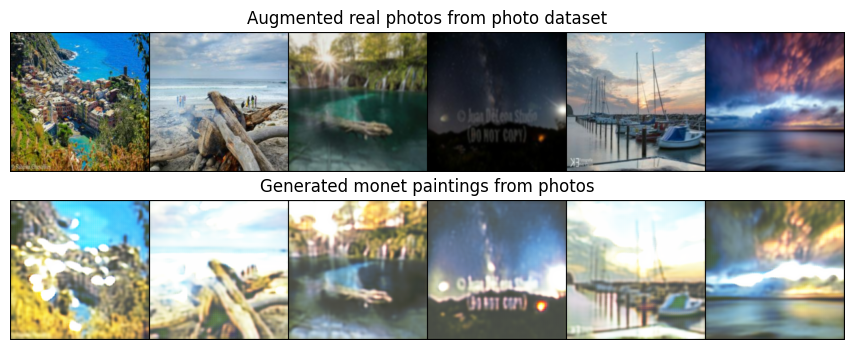

Epoch 20/100
Generator loss: 1.2437
Discriminator (Critic) loss: -0.0638


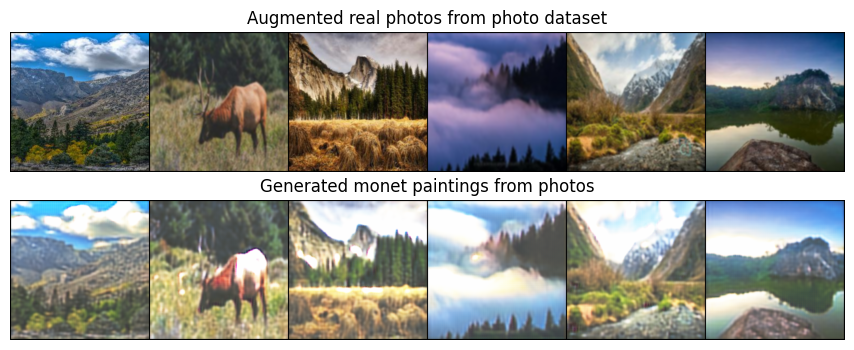

Epoch 40/100
Generator loss: 1.0790
Discriminator (Critic) loss: -0.0717


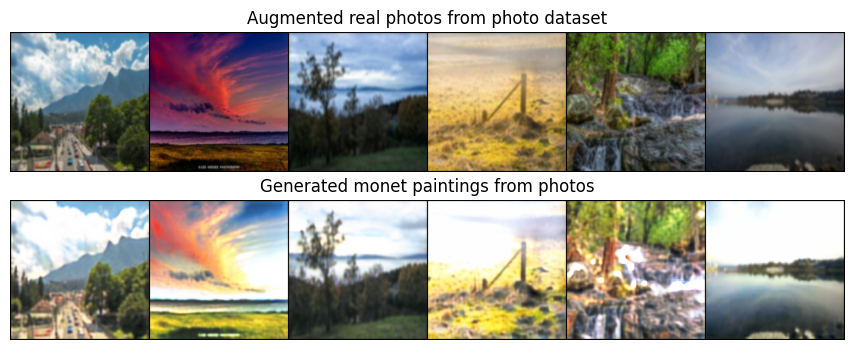

Epoch 60/100
Generator loss: 0.7859
Discriminator (Critic) loss: -0.0929


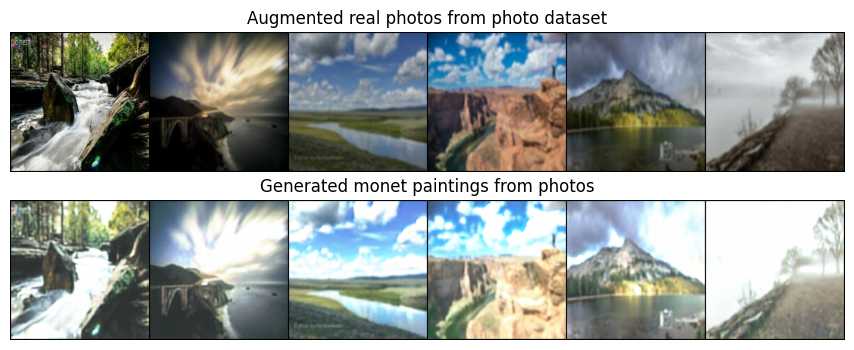

Epoch 80/100
Generator loss: 0.8605
Discriminator (Critic) loss: -0.0336


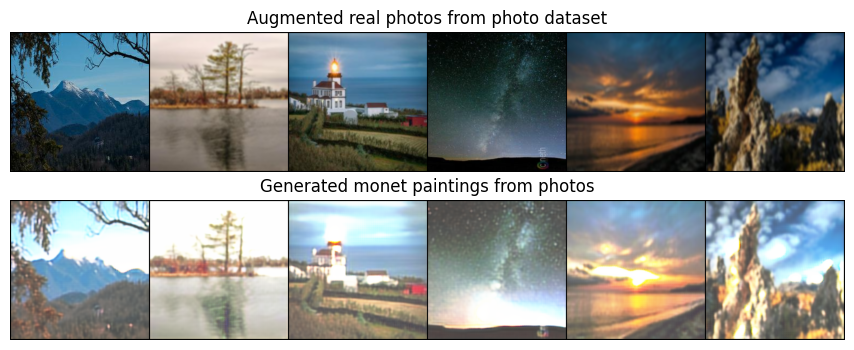

Epoch 100/100
Generator loss: 0.9091
Discriminator (Critic) loss: -0.0145


In [15]:
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01
lambda_identity = 5
identity_loss_function = nn.L1Loss()

for epoch in tqdm(range(n_epoches)):
    for i, (real_photo, real_monet) in enumerate(zip(photo_loader, monet_loader)):

        # Prepare the real and generated data
        real_photo = real_photo.type(Tensor)
        real_monet = real_monet.type(Tensor)

        # Train the Critic - We wish to maximize the difference between the fake and the real images - Max(E[critic(real)] - E[critic(fake)])
        for _ in range(CRITIC_ITERATIONS):
            optimizer_D.zero_grad()

            # Generate a batch of images
            artificial_monet = G(real_photo)

            # Critic scores for real and fake images
            critic_real = D(real_monet).reshape(-1)
            critic_fake = D(artificial_monet.detach()).reshape(-1)

            # Calculate the loss for the critic
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
            loss_critic.backward(retain_graph=True)
            optimizer_D.step()

            # Weight clipping - to satisfy lipshitz constraint
            for p in D.parameters():
                p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

        # Train the Generator - We wish to minimize 
        optimizer_G.zero_grad()

        # Since we just updated D, perform another forward pass of all-fake batch through D
        gen_fake = D(artificial_monet).reshape(-1)

        # Calculate G's loss
        loss_G_Wasserstein = -torch.mean(gen_fake)

        # Calculate identity loss
        identity_loss = identity_loss_function(artificial_monet, real_photo)

        # Total generator loss
        loss_G = loss_G_Wasserstein + lambda_identity * identity_loss
        
        loss_G.backward()
        optimizer_G.step()
        
    if (epoch + 1) % display_epoch == 0:
        test_real_photo, test_real_monet = next(iter(zip(photo_loader, monet_loader)))
        sample_images(test_real_photo.type(Tensor))

        print(f'Epoch {epoch + 1}/{n_epoches}')
        print(f'Generator loss: {loss_G.item():.4f}')
        print(f'Discriminator (Critic) loss: {loss_critic.item():.4f}')

# **Submission**

In [16]:
# create path to save created monet paintings
transformed_save_dir = '../images'
if not os.path.exists(transformed_save_dir):
    os.makedirs(transformed_save_dir)
    
# freeze some network params to generate imgs
G.eval()


for i, real_photos in enumerate(photo_loader):
    real_photos = real_photos.to(device)
    with torch.no_grad():
        monet_style_imgs = G(real_photos)

    # Save each transformed image
    for j, img in enumerate(monet_style_imgs):
        save_path = os.path.join(transformed_save_dir, f'monet_painting_{i * batch_size + j}.png')
        torchvision.utils.save_image(img, save_path)

print(f"Transformed images are saved in {transformed_save_dir}")

shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

Transformed images are saved in ../images


'/kaggle/working/images.zip'